## Simple GCN

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(root)

In [2]:
import torch
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

import scripts.data.dataset as ds
from scripts.model.simple_gcn import SimpleGCN
from scripts.train.train import train_one_epoch
from scripts.evaluate.evaluate import evaluate, compare_ytrue_ypred

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Preparing the dataset

Download the dataset

In [4]:
dataset = ds.load_qm9_dataset(root=f"{root}/data/QM9")
ds.describe_dataset(dataset)

Dataset: QM9(130831):
[====================]
Number of graphs: 130831
Number of features: 11
Number of classes: 19

First node data:
[====================]
Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])
Number of nodes: 5
Number of edges: 8
Average node degree: 1.60
Has isolated nodes: False
Has self-loops: False
Is undirected: True


/home/alex/miniconda3/envs/torchgpu/lib/python3.11/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and torc

Split the dataset into training and test sets

In [5]:
train_dataset, test_dataset = ds.split_dataset(dataset, training_perc=0.9)

Number of training graphs: 117747
Number of test graphs: 13084


Normalize the target property in the training set

In [6]:
target_idx = 11
train_mean, train_std = ds.normalize_train_set(train_dataset, target_idx=target_idx)
train_mean = train_mean.to(device)
train_std = train_std.to(device)

Target statistics - Mean: 31.6199, Std: 4.0655


Create the DataLoaders for the training and test sets

In [7]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Training

In [8]:
# Model, optimizer, loss, scheduler
model = SimpleGCN(input_channels=dataset.num_features, hidden_channels=128).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = torch.nn.L1Loss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

# Training loop with early stopping and checkpointing
max_epochs = 500
patience = 20
min_delta = 1e-4
best_val = float('inf')
epochs_no_improve = 0
save_path = f"{root}/models/simple_gcn_model.pt"

print("Starting training...")
for epoch in range(1, max_epochs + 1):

    train_loss = train_one_epoch(
        model, train_loader, optimizer, criterion, device,
        train_mean, train_std, target_idx, model_type="gcn")
    
    train_mae = evaluate(
        model, train_loader, device, train_mean,
        train_std, target_idx, model_type="gcn")
    
    val_mae = evaluate(
        model, test_loader, device, train_mean,
        train_std, target_idx, model_type="gcn")
    
    scheduler.step(val_mae)

    # Check for improvement and checkpoint
    if val_mae < best_val - min_delta:
        best_val = val_mae
        epochs_no_improve = 0
        torch.save(model.state_dict(), save_path)
        improved = " *"
    else:
        epochs_no_improve += 1
        improved = ""

    if epoch % 5 == 0 or epochs_no_improve == 0:
        print(f"[*] Epoch {epoch:03d}  Train loss: {train_loss:.4f}  Train MAE: {train_mae:.4f}  Val MAE: {val_mae:.4f}{improved}")

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch} (no val MAE improvement for {patience} epochs).")
        break


# Load best model for final evaluation
model.load_state_dict(torch.load(save_path))
final_val = evaluate(
        model, test_loader, device, train_mean,
        train_std, target_idx, model_type="gcn")

print(f"Best validation MAE: {best_val:.4f}")
print(f"Final evaluated MAE: {final_val:.4f}")
print(f"Test set mean: {train_mean:.4f}, std: {train_std:.4f}")
print(f"Relative MAE: {(best_val/train_std.abs()):.4f} standard deviations")

# Compare to baseline (predicting mean)
baseline_mae = train_std.abs().item()
print(f"Baseline MAE (predicting mean): {baseline_mae:.4f}")
print(f"Improvement over baseline: {(baseline_mae/best_val):.2f}x")

Starting training...
[*] Epoch 001  Train loss: 0.4756  Train MAE: 1.6583  Val MAE: 1.6568 *
[*] Epoch 003  Train loss: 0.4018  Train MAE: 1.6562  Val MAE: 1.6487 *
[*] Epoch 004  Train loss: 0.3914  Train MAE: 1.5427  Val MAE: 1.5422 *
[*] Epoch 005  Train loss: 0.3781  Train MAE: 1.4640  Val MAE: 1.4587 *
[*] Epoch 007  Train loss: 0.3604  Train MAE: 1.4046  Val MAE: 1.3962 *
[*] Epoch 010  Train loss: 0.3453  Train MAE: 1.3574  Val MAE: 1.3445 *
[*] Epoch 014  Train loss: 0.3358  Train MAE: 1.3144  Val MAE: 1.3060 *
[*] Epoch 015  Train loss: 0.3317  Train MAE: 1.3307  Val MAE: 1.3210
[*] Epoch 018  Train loss: 0.3282  Train MAE: 1.2830  Val MAE: 1.2748 *
[*] Epoch 020  Train loss: 0.3265  Train MAE: 1.3497  Val MAE: 1.3515
[*] Epoch 021  Train loss: 0.3245  Train MAE: 1.2780  Val MAE: 1.2690 *
[*] Epoch 025  Train loss: 0.3210  Train MAE: 1.2729  Val MAE: 1.2668 *
[*] Epoch 026  Train loss: 0.3212  Train MAE: 1.2584  Val MAE: 1.2467 *
[*] Epoch 030  Train loss: 0.3189  Train MAE: 1

/tmp/ipykernel_396916/1212964146.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


Best validation MAE: 1.1960
Final evaluated MAE: 1.1960
Test set mean: 31.6199, std: 4.0655
Relative MAE: 0.2942 standard deviations
Baseline MAE (predicting mean): 4.0655
Improvement over baseline: 3.40x


### Testing the performance

In [9]:
model = SimpleGCN(input_channels=dataset.num_features, hidden_channels=128)
model.load_state_dict(torch.load(f'{root}/models/simple_gcn_model.pt'))
model.to(device)

test_mae = evaluate(
        model, test_loader, device, train_mean,
        train_std, target_idx, model_type="gcn")

print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Test set MAE: {test_mae:.4f}")
print(f"Test set mean: {train_mean:.4f}, std: {train_std:.4f}")
print(f"Relative MAE: {(test_mae/train_std.abs()):.4f} standard deviations")

/tmp/ipykernel_396916/2304292608.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{root}/models/simple_gcn_model.pt'))


Number of parameters: 34689
Test set MAE: 1.1960
Test set mean: 31.6199, std: 4.0655
Relative MAE: 0.2942 standard deviations


R² score on test set: 0.7042


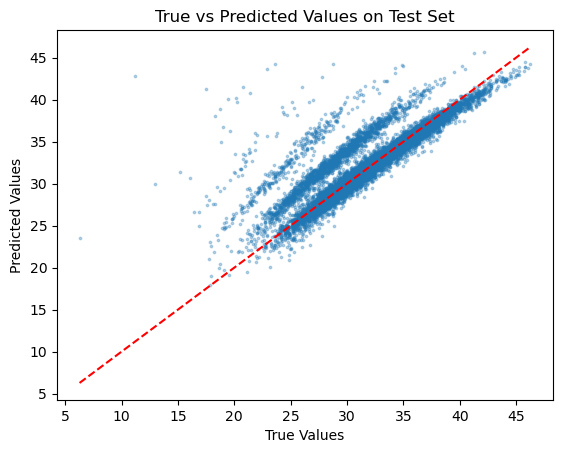

In [10]:
ytrue, ypred = compare_ytrue_ypred(
        model, test_loader, device, train_mean,
        train_std, target_idx, model_type="gcn")
ytrue = torch.cat(ytrue).cpu().numpy()
ypred = torch.cat(ypred).cpu().numpy()

# Calculate R² score
r2 = r2_score(ytrue, ypred)
print(f"R² score on test set: {r2:.4f}")

# Plot true vs predicted valuesS
plt.scatter(ytrue, ypred, alpha=0.3, s=3)
plt.plot([ytrue.min(), ytrue.max()], [ytrue.min(), ytrue.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values on Test Set")
plt.show()